In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('dataset_mood_smartphone.csv')  # replace with the actual dataset path


In [10]:
#CLEANING DATA
import pandas as pd

# 1. Define expected ranges for each variable.
#    Format: variable_name: (min_value, max_value)
expected_ranges = {
    'mood': (1, 10),
    'circumplex.valence': (-2, 2),
    'circumplex.arousal': (-2, 2),
    'activity': (0, 1),
    # If you have more variables, add them here:
    # 'screen': (0, 1440),  # e.g., if screen usage is in minutes
    # 'appCat.social': (0, 1440), 
    # 'call': (0, 1),       # if call is an indicator
    # 'sms': (0, 1),
    # etc.
}

# 2. For each variable in expected_ranges, find rows that are out of range
outliers_list = []  # to store all out-of-range rows

for var_name, (min_val, max_val) in expected_ranges.items():
    # Filter dataset rows that match this variable
    mask_var = (df['variable'] == var_name)
    
    # Among these rows, find those whose value is < min_val or > max_val
    mask_outlier = (df['value'] < min_val) | (df['value'] > max_val)
    
    # Combine the two masks to find out-of-range rows for this variable
    outliers = df[mask_var & mask_outlier]
    
    if not outliers.empty:
        print(f"Variable '{var_name}': Found {len(outliers)} out-of-range rows.")
        outliers_list.append(outliers)

# 3. Combine all out-of-range rows (if you want a single dataframe of outliers)
if outliers_list:
    df_outliers = pd.concat(outliers_list, ignore_index=True)
    print("\nSummary of out-of-range rows:")
    print(df_outliers.head())
else:
    print("No out-of-range values found based on the defined expected ranges.")

No out-of-range values found based on the defined expected ranges.


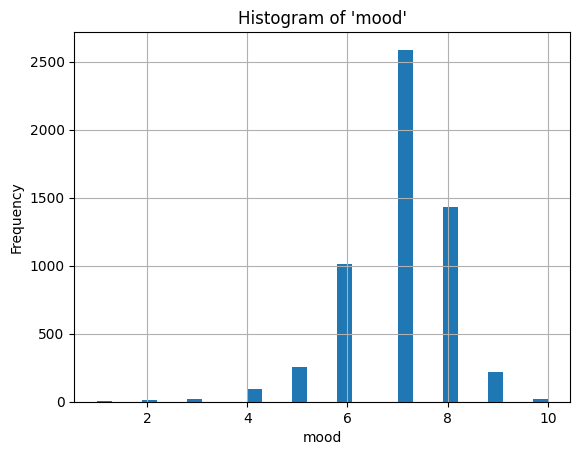

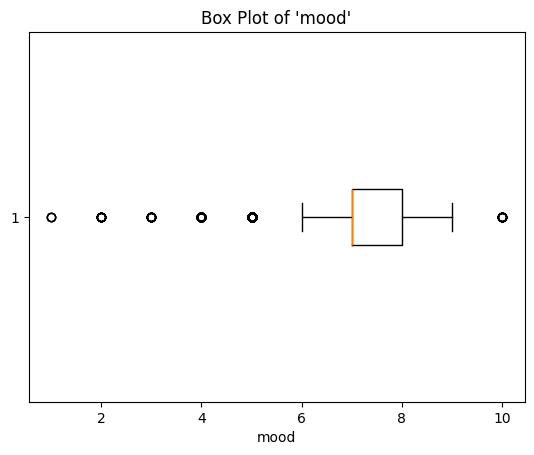

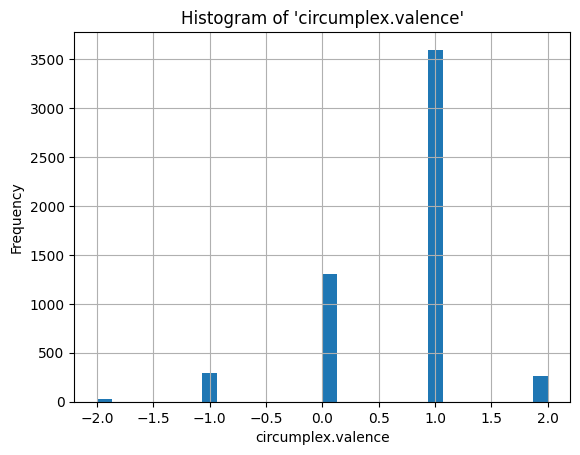

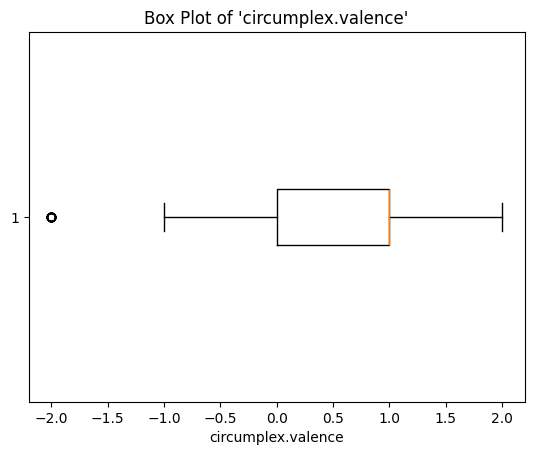

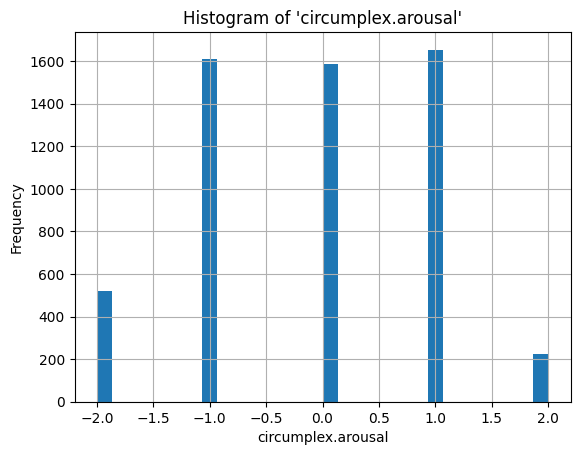

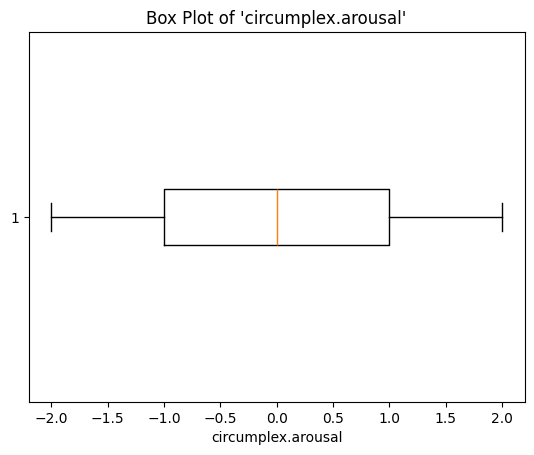

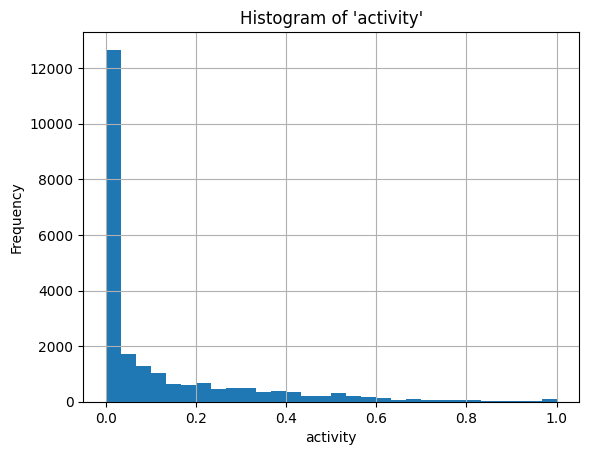

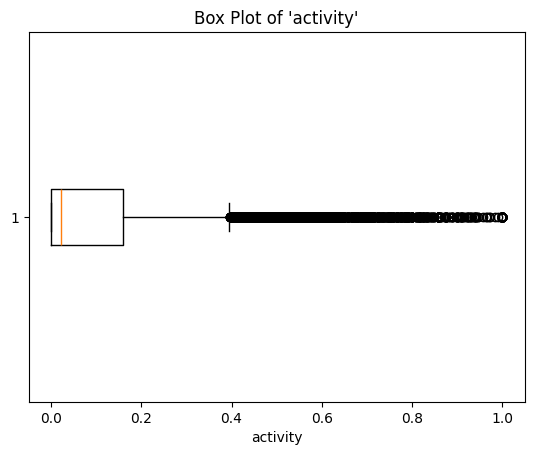

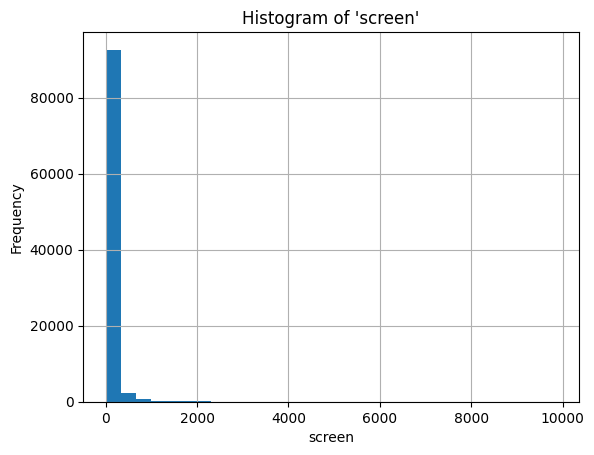

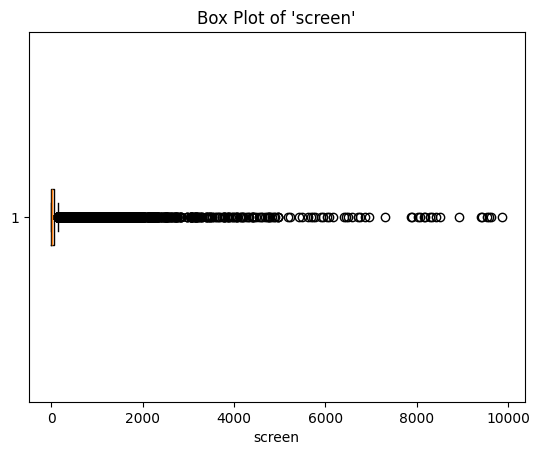

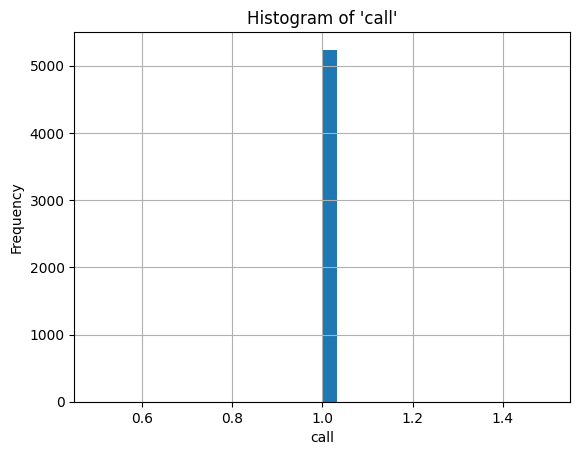

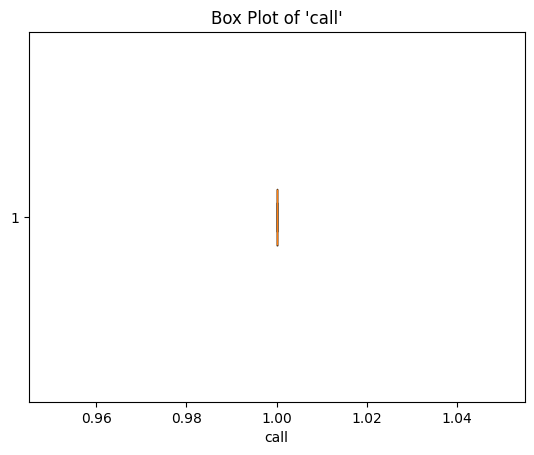

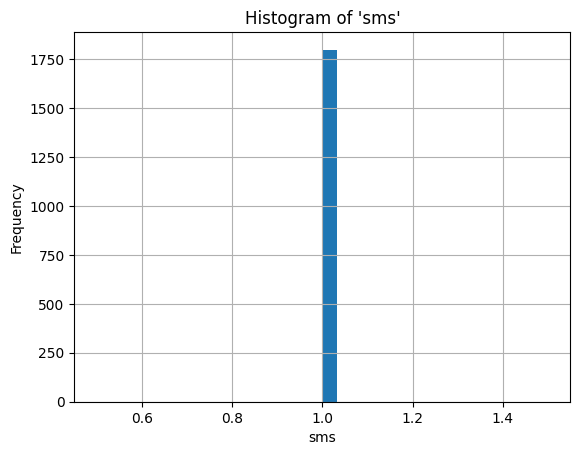

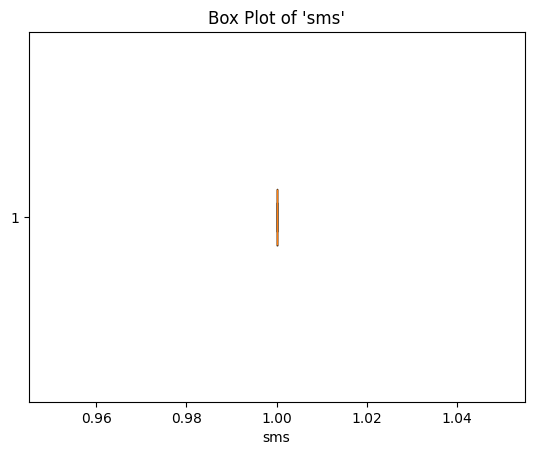

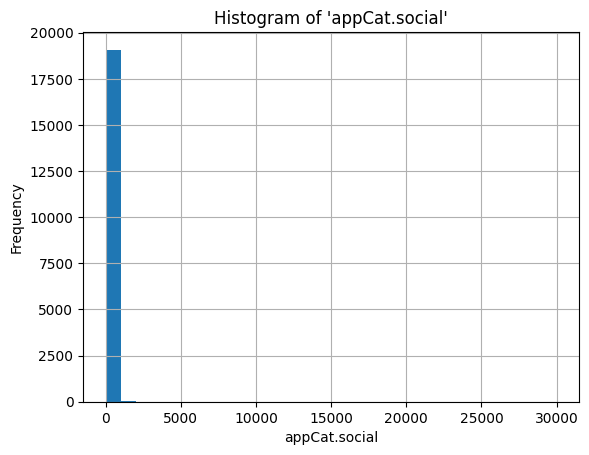

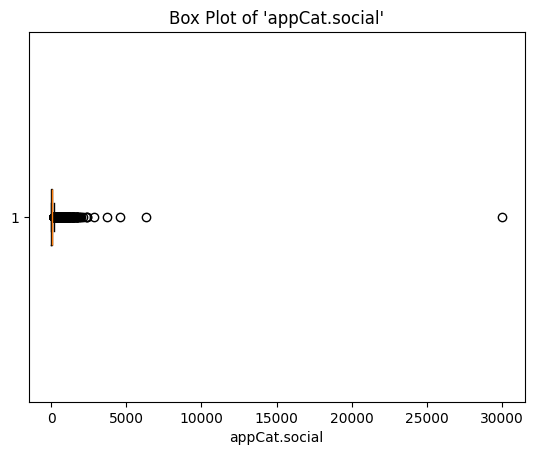

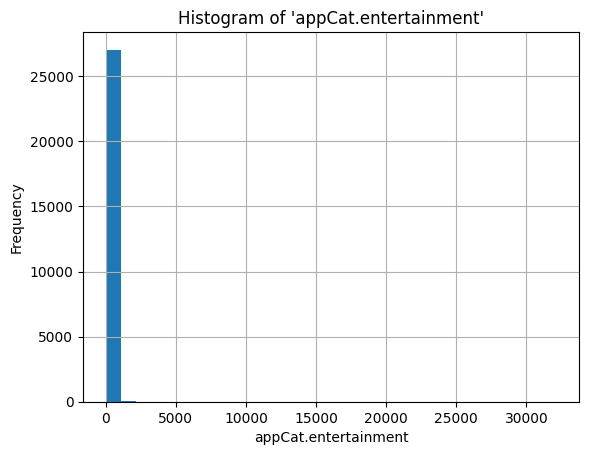

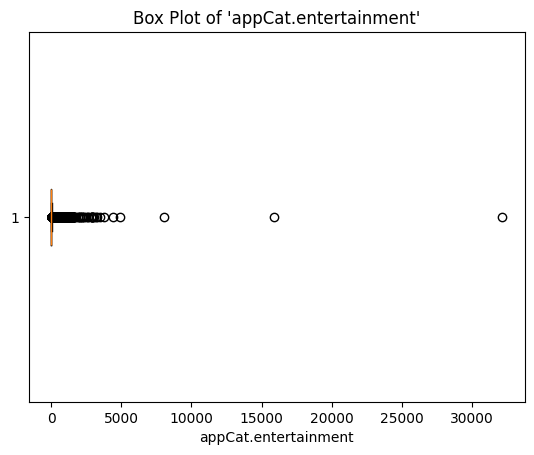

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define which variables you want to visualize
#    (Adjust this list to match the variables actually in your dataset)
variables_of_interest = [
    'mood',
    'circumplex.valence',
    'circumplex.arousal',
    'activity',
    'screen',
    'call',
    'sms',
    'appCat.social',
    'appCat.entertainment'
]

# 2. Loop over each variable and plot a histogram
for var_name in variables_of_interest:
    # Filter to rows for this variable
    df_var = df[df['variable'] == var_name]

    # Skip if empty
    if df_var.empty:
        print(f"No rows found for variable '{var_name}'. Skipping...")
        continue

    # Convert to numeric if necessary
    values = pd.to_numeric(df_var['value'], errors='coerce').dropna()

    # Plot histogram
    plt.figure()
    values.hist(bins=30)  # 30 bins is arbitrary; adjust as needed
    plt.title(f"Histogram of '{var_name}'")
    plt.xlabel(var_name)
    plt.ylabel("Frequency")
    plt.show()

    # (Optional) Also plot a box plot to see outliers/percentiles
    plt.figure()
    plt.boxplot(values, vert=False)
    plt.title(f"Box Plot of '{var_name}'")
    plt.xlabel(var_name)
    plt.show()

In [ ]:
import pandas as pd
import numpy as np

# ---------------------------
# 1) Convert time & extract date, weekday
# ---------------------------
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['date'] = df['time'].dt.date            # e.g. 2025-03-14
df['weekday'] = df['time'].dt.dayofweek    # Monday=0, Sunday=6

# Optional: if you want the weekday name instead:
# df['weekday_name'] = df['time'].dt.day_name()

# We'll create a reference for how many total rows per (id, date)
df['entry_count'] = 1  # helper for counting total rows later

# ---------------------------
# 2) Aggregate "countable" variables: call, sms, screen, appCat.* 
#    We'll sum these per day
# ---------------------------
# We'll define which variables to sum. Adjust this list as needed.
variables_to_sum = [
      'mood',
    'activity',
    'circumplex.arousal',
    'circumplex.valence',
    'screen',
    'call',
    'sms',
    'appCat.builtin',
    'appCat.communication',
    'appCat.entertainment',
    'appCat.finance',
    'appCat.game',
    'appCat.office',
    'appCat.other',
    'appCat.social',
    'appCat.travel',
    'appCat.unknown',
    'appCat.utilities',
    'appCat.weather',
]

df_sum = df[df['variable'].isin(variables_to_sum)].copy()

# Group by (id, date) and variable, then sum 'value'
df_sum_grouped = df_sum.groupby(['id', 'date','variable'])['value'].sum().unstack(fill_value=0)

# This gives a DataFrame with index=(id, date) and columns for each variable_to_sum
df_sum_grouped = df_sum_grouped.reset_index()  # so we have 'id', 'date' as columns

# ---------------------------
# 3) Aggregate "mood" variable: average, variance, count
# ---------------------------
df_mood = df[df['variable'] == 'mood'].copy()
df_mood_grouped = df_mood.groupby(['id','date'])['value'].agg(
    mood_avg='mean',
    mood_var='var',
    mood_count='count'
).reset_index()

# ---------------------------
# 4) (Optional) Count total entries per day (for all variables)
# ---------------------------
df_entries = df.groupby(['id','date'])['entry_count'].sum().reset_index(name='total_entries')

# ---------------------------
# 5) Merge everything
# ---------------------------
# We'll merge on (id, date). We'll do an outer merge so we don't lose days that 
# have mood but no calls, or calls but no mood, etc.
daily_merged = pd.merge(df_sum_grouped, df_mood_grouped, on=['id','date'], how='outer')

# Merge the total_entries as well
daily_merged = pd.merge(daily_merged, df_entries, on=['id','date'], how='outer')

# We also want weekday. But that's not aggregated, 
# we can pull it from a typical row representing that day.
# Easiest approach: merge from a minimal subset with id, date, weekday.
df_weekday = df[['id','date','weekday']].drop_duplicates()
daily_merged = pd.merge(daily_merged, df_weekday, on=['id','date'], how='left')

# ---------------------------
# 6) Inspect the final daily DataFrame
# ---------------------------
print(daily_merged.head(10))

        id        date  appCat.builtin  appCat.entertainment  appCat.social  \
0  AS14.01  2014-02-17             0.0                   0.0            0.0   
1  AS14.01  2014-02-18             0.0                   0.0            0.0   
2  AS14.01  2014-02-19             0.0                   0.0            0.0   
3  AS14.01  2014-02-20             0.0                   0.0            0.0   
4  AS14.01  2014-02-21             0.0                   0.0            0.0   
5  AS14.01  2014-02-22             0.0                   0.0            0.0   
6  AS14.01  2014-02-25             0.0                   0.0            0.0   
7  AS14.01  2014-02-26             0.0                   0.0            0.0   
8  AS14.01  2014-02-27             NaN                   NaN            NaN   
9  AS14.01  2014-02-28             0.0                   0.0            0.0   

   call  screen  sms  mood_avg  mood_var  mood_count  total_entries  weekday  
0   2.0     0.0  0.0       NaN       NaN         Na